In [1]:
!pip install transformers torchaudio torchcodec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 82.8 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Copie instantanée (une fois l'upload fini)
!cp "/content/drive/MyDrive/dataset_pena.zip" "/content/dataset.zip"
!unzip -q "/content/dataset.zip" -d "/content"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer
import matplotlib.pyplot as plt
from IPython.display import Audio, display

CONFIG = {
    "sample_rate": 32000,
    "duration": 2.0,
    "n_mels": 64,
    "hidden_size": 1024,
    "num_layers": 3,
    "text_emb_dim": 768,
    "batch_size": 64,
    "learning_rate": 1e-4,
    "epochs": 100,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "dataset_path": "/content/dataset_pena",
    "csv_name": "metadata.csv",
    "save_dir": "/content/drive/MyDrive/Pena_Project"
}

os.makedirs(CONFIG['save_dir'], exist_ok=True)

In [4]:
import os
import pandas as pd

data = []

files = sorted(os.listdir(CONFIG['dataset_path']))
for filename in files:
    if filename.endswith(".wav"):
        audio_filename = filename

        text_filename = filename.replace(".wav", ".txt")
        text_path = os.path.join(CONFIG['dataset_path'], text_filename)

        if os.path.exists(text_path):
            with open(text_path, "r", encoding="utf-8") as f:
                prompt_text = f.read().strip()

            data.append([audio_filename, prompt_text])
        else:
            print(f"no text file for {audio_filename}")

if len(data) > 0:
    df = pd.DataFrame(data, columns=["file_name", "prompt"])
    csv_path = os.path.join(CONFIG['dataset_path'], "metadata.csv")
    df.to_csv(csv_path, index=False)
    print(f"Saved metadata to {csv_path}")
    print("5 first line:")
    print(df.head())
else:
    print("error nothing is valid")

Saved metadata to /content/dataset_pena/metadata.csv
5 first line:
      file_name                                             prompt
0   slice_1.wav  Music Musical instrument Orchestra Brass instr...
1  slice_10.wav  Music Musical instrument Orchestra Brass instr...
2  slice_11.wav  Music Musical instrument Orchestra Brass instr...
3  slice_12.wav  Music Musical instrument Orchestra Brass instr...
4  slice_13.wav  Music Musical instrument Orchestra Brass instr...


In [5]:
import torch
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer

class SimpleAudioLSTM(nn.Module):
    def __init__(self, audio_dim, hidden_size, num_layers):
        super().__init__()


        self.lstm = nn.LSTM(
            input_size=audio_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.3
        )

        self.fc_out = nn.Linear(hidden_size, audio_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, audio_sequence):
        lstm_out, _ = self.lstm(audio_sequence)

        raw_output = self.fc_out(lstm_out)
        prediction = self.sigmoid(raw_output)

        return prediction

In [8]:
from transformers import AutoTokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleAudioLSTM(
    audio_dim=64,
    hidden_size=512,
    num_layers=3
).to(device)

In [9]:
temp_transform = T.MelSpectrogram(sample_rate=CONFIG['sample_rate'], n_fft=1024, n_mels=CONFIG['n_mels'])
global_min = float('inf')
global_max = float('-inf')

wav_files = [f for f in os.listdir(CONFIG['dataset_path']) if f.endswith('.wav')]

for wav_file in wav_files:
    path = os.path.join(CONFIG['dataset_path'], wav_file)
    try:
        waveform, sr = torchaudio.load(path)
        if sr != CONFIG['sample_rate']:
            waveform = T.Resample(sr, CONFIG['sample_rate'])(waveform)

        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)

        spec = temp_transform(waveform)
        spec = torch.log(spec + 1e-5)

        current_min = spec.min().item()
        current_max = spec.max().item()

        if current_min < global_min: global_min = current_min
        if current_max > global_max: global_max = current_max

    except Exception as e:
        continue

print(f"VRAI Min: {global_min}")
print(f"VRAI Max: {global_max}")

CONFIG['min_db'] = global_min
CONFIG['max_db'] = global_max

VRAI Min: -11.512925148010254
VRAI Max: 9.641684532165527


In [10]:
class PenaTextAudioDataset(Dataset):
    def __init__(self, root_dir, csv_file, config):
        self.root_dir = root_dir
        self.data = pd.read_csv(os.path.join(root_dir, csv_file))
        self.sr = config['sample_rate']
        self.target_len = int(self.sr * config['duration'])
        # On récupère les stats calculées plus haut
        self.min_db = config['min_db']
        self.max_db = config['max_db']

        self.spec_transform = T.MelSpectrogram(
            sample_rate=self.sr, n_fft=1024, n_mels=config['n_mels']
        )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        filename = self.data.iloc[idx, 0]
        # On ignore le prompt, on ne s'en sert plus !
        path = os.path.join(self.root_dir, filename)

        try:
            waveform, sr = torchaudio.load(path)
            if sr != self.sr:
                resampler = T.Resample(sr, self.sr)
                waveform = resampler(waveform)
            if waveform.shape[0] > 1:
                waveform = torch.mean(waveform, dim=0, keepdim=True)

            if waveform.shape[1] > self.target_len:
                start = np.random.randint(0, waveform.shape[1] - self.target_len)
                waveform = waveform[:, start:start+self.target_len]
            elif waveform.shape[1] < self.target_len:
                pad_size = self.target_len - waveform.shape[1]
                waveform = torch.nn.functional.pad(waveform, (0, pad_size))

            spec = self.spec_transform(waveform)
            spec = torch.log(spec + 1e-5)

            spec = (spec - self.min_db) / (self.max_db - self.min_db)

            spec = torch.clamp(spec, 0.0, 1.0)
            spec = spec.squeeze(0).transpose(0, 1)

            return spec

        except Exception as e:
            print(f"Erreur fichier {filename}: {e}")
            return torch.zeros(100, CONFIG['n_mels'])

In [11]:
import random

def train_one_epoch(dataloader, model, optimizer, criterion, device, teacher_forcing_ratio=0.5):
    model.train()
    total_loss = 0
    criterion = nn.L1Loss()

    for batch_idx, audio in enumerate(dataloader):

        audio = audio.to(device)
        batch_size, seq_len, n_mels = audio.shape

        optimizer.zero_grad()
        loss = 0

        decoder_input = audio[:, 0:1, :]

        for t in range(1, seq_len):
            pred_frame = model(decoder_input)
            pred_frame = pred_frame[:, -1:, :]

            target_frame = audio[:, t:t+1, :]
            loss += criterion(pred_frame, target_frame)

            use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

            if use_teacher_forcing:
                decoder_input = target_frame
            else:
                decoder_input = pred_frame.detach()

        loss = loss / seq_len
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(dataloader)

In [12]:
def spectrogram_to_audio(spec):
    spec = spec * (CONFIG['max_db'] - CONFIG['min_db']) + CONFIG['min_db']

    if spec.size(0) != CONFIG['n_mels']:
        spec = spec.transpose(0, 1)

    spec = torch.exp(spec)

    inverse_mel = T.InverseMelScale(
        n_stft=1024 // 2 + 1,
        n_mels=CONFIG['n_mels'],
        sample_rate=CONFIG['sample_rate']
    ).to(spec.device)

    linear_spec = inverse_mel(spec)
    griffin_lim = T.GriffinLim(n_fft=1024).to(spec.device)

    return griffin_lim(linear_spec)

Epoch [1/100] 	 Loss: 0.154027
Epoch [2/100] 	 Loss: 0.153357
Epoch [3/100] 	 Loss: 0.151432
Epoch [4/100] 	 Loss: 0.154166
Epoch [5/100] 	 Loss: 0.151126
Epoch [6/100] 	 Loss: 0.151179
Epoch [7/100] 	 Loss: 0.154802
Epoch [8/100] 	 Loss: 0.154500
Epoch [9/100] 	 Loss: 0.149526
Epoch [10/100] 	 Loss: 0.150559
Epoch [11/100] 	 Loss: 0.153153
Epoch [12/100] 	 Loss: 0.151883
Epoch [13/100] 	 Loss: 0.148780
Epoch [14/100] 	 Loss: 0.150167
Epoch [15/100] 	 Loss: 0.154631
Epoch [16/100] 	 Loss: 0.152530
Epoch [17/100] 	 Loss: 0.148044
Epoch [18/100] 	 Loss: 0.150651
Epoch [19/100] 	 Loss: 0.150025
Epoch [20/100] 	 Loss: 0.154426
Epoch [21/100] 	 Loss: 0.147061
Epoch [22/100] 	 Loss: 0.149030
Epoch [23/100] 	 Loss: 0.148078
Epoch [24/100] 	 Loss: 0.141994
Epoch [25/100] 	 Loss: 0.143201
Epoch [26/100] 	 Loss: 0.146297
Epoch [27/100] 	 Loss: 0.142064
Epoch [28/100] 	 Loss: 0.136141
Epoch [29/100] 	 Loss: 0.137553
Epoch [30/100] 	 Loss: 0.140556
Epoch [31/100] 	 Loss: 0.134107
Epoch [32/100] 	 

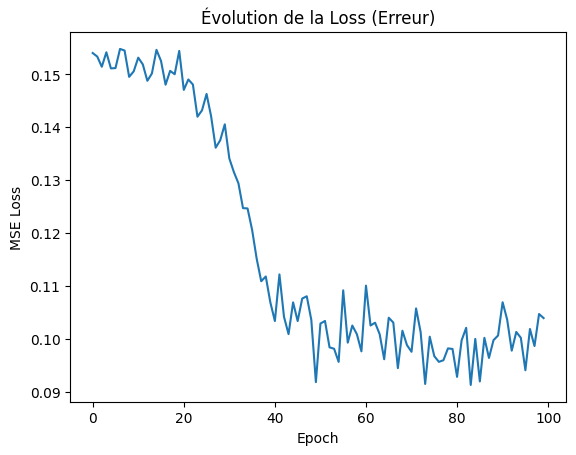

In [13]:
dataset = PenaTextAudioDataset(CONFIG['dataset_path'], CONFIG['csv_name'], CONFIG)
dataloader = DataLoader(dataset, batch_size=CONFIG['batch_size'], shuffle=True)

model = SimpleAudioLSTM(
    audio_dim=CONFIG['n_mels'],
    hidden_size=CONFIG['hidden_size'],
    num_layers=CONFIG['num_layers']
).to(CONFIG['device'])

optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'])

loss_history = []

for epoch in range(CONFIG['epochs']):
    ratio = max(0.3, 1.0 - (epoch / (CONFIG['epochs'] * 0.8)))

    avg_loss = train_one_epoch(dataloader, model, optimizer, None, CONFIG['device'], teacher_forcing_ratio=ratio)

    loss_history.append(avg_loss)
    print(f"Epoch [{epoch+1}/{CONFIG['epochs']}] \t Loss: {avg_loss:.6f}")

plt.plot(loss_history)
plt.title("Évolution de la Loss (Erreur)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()

In [14]:
import torch
import torchaudio
from IPython.display import Audio, display

model.eval()

real_spec = dataset[0]
seed_audio = real_spec[:100, :]
seed = seed_audio.unsqueeze(0).to(CONFIG['device'])

gen_seq = seed.clone()
curr_in = seed

with torch.no_grad():
    for i in range(500):
        pred = model(curr_in)
        next_frame = pred[:, -1:, :]

        noise = torch.randn_like(next_frame) * 0.01
        next_frame = next_frame + noise

        gen_seq = torch.cat((gen_seq, next_frame), dim=1)
        curr_in = torch.cat((curr_in, next_frame), dim=1)
        if curr_in.size(1) > 100: curr_in = curr_in[:, -100:, :]

waveform = spectrogram_to_audio(gen_seq.squeeze(0).cpu())
display(Audio(waveform, rate=CONFIG['sample_rate']))

Min: -0.04
Max: 1.03
Mean: 0.62


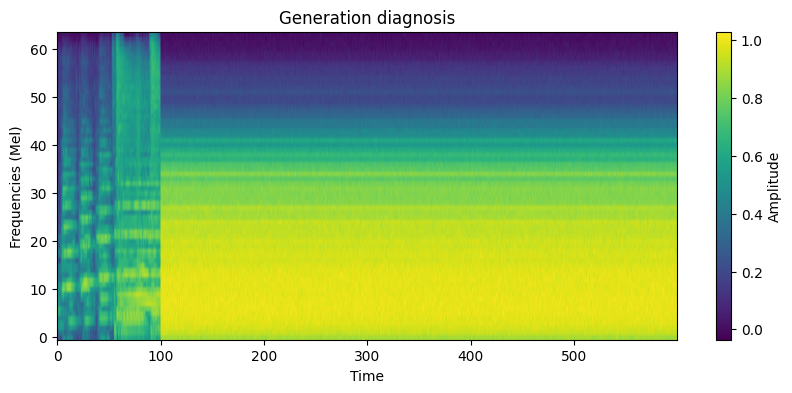

In [15]:
import matplotlib.pyplot as plt
import torch

def diagnose_generation(generated_spec):
    spec = generated_spec.squeeze().cpu().detach().numpy()

    print(f"Min: {spec.min():.2f}")
    print(f"Max: {spec.max():.2f}")
    print(f"Mean: {spec.mean():.2f}")

    plt.figure(figsize=(10, 4))
    plt.imshow(spec.T, origin='lower', aspect='auto', cmap='viridis')
    plt.colorbar(label='Amplitude')
    plt.title("Generation diagnosis")
    plt.xlabel("Time")
    plt.ylabel("Frequencies (Mel)")
    plt.show()

diagnose_generation(gen_seq)